In [1]:
# lets import xarray and numpy
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as feature

## Load the model output

In [231]:
ism = {}
# NorESM1-M RCP8.5
ism['issm_exp05'] = xr.open_mfdataset("JPL1_ISSM/exp05/*.nc")
ism['cism_exp05'] = xr.open_mfdataset("NCAR_CISM/exp05/*.nc")

# NorESM1-M RCP2.6
ism['issm_exp07'] = xr.open_mfdataset("JPL1_ISSM/exp07/*.nc")
ism['cism_exp07'] = xr.open_mfdataset("NCAR_CISM/exp07/*.nc")

# Control
ism['issm_ctrl'] = xr.open_mfdataset("JPL1_ISSM/ctrl_proj/*.nc")
ism['cism_ctrl'] = xr.open_mfdataset("NCAR_CISM/ctrl_proj/*.nc")

# Not all data arrays have x,y coordinates, so we need to set a consistent coordinate system
# We'll use a grid with spacings of 1 km by 1 km, centered at (0,0)
GRID_EXTENT = 3040 # km

for exp in ism.keys():
    print(exp)
    grid_resolution_x = 2 * GRID_EXTENT / (len(ism[exp].x) - 1) # km
    grid_resolution_y = 2 * GRID_EXTENT / (len(ism[exp].y) - 1) # km
    x_km, y_km = (ism[exp].x * grid_resolution_x , ism[exp].y * grid_resolution_y) 
    x_km -= grid_extent
    y_km -= grid_extent
    gridspace_area = grid_resolution_x*grid_resolution_y # km^2
    coords = {"x":x_km , "y":y_km }
    ## TODO: use WGS84
    #ism[exp] = ism[exp].rename({'ny':'y'})
    ism[exp] = ism[exp].assign_coords(coords)

## Functions for computing ice mass and sea level rise

In [235]:
# Constants
ICE_DENSITY = 0.917 # in Gt / km ^3
WATER_DENSITY = 1.027  # Gt / km ^3
OCEAN_SURFACE_AREA = 361.8 * 10**6  # km²

def sea_level_rise(total_ice_mass_gt):

    # Convert total ice mass to water equivalent volume (in km³)
    water_volume_km3 = total_ice_mass_gt * (ICE_DENSITY / WATER_DENSITY)

    # Calculate the sea level rise in mm
    sea_level_rise_mm = (water_volume_km3 / OCEAN_SURFACE_AREA) * 10**6  # mm

    return sea_level_rise_mm

def get_ice_mass_area(lithk, fraction=None):
    
    thickness =  lithk * 1e-3 # convert to km units
    
    ones_array = xr.DataArray(np.ones_like(thickness), coords=thickness.coords, dims=thickness.dims)
    masked_ones = ones_array.where(~np.isnan(thickness))
    
    # Mask the DataArray to replace NaNs with 0
    masked_data = thickness.where(~np.isnan(thickness), other=0)
    if fraction is not None:
        fraction = fraction.where(~np.isnan(fraction), other=0)
        masked_data *= fraction
        masked_ones *= fraction
    
    # Integrate over the x and y coordinates
    dx = np.gradient(thickness.coords['x']) # in km 
    dy = np.gradient(thickness.coords['y']) # in km 
    
    # Create an area array if the grid spacing varies
    integrated_area = (masked_ones * dx[:, np.newaxis] * dy).sum(dim=['x', 'y'])
    integrated_area = integrated_area.compute()/1e7 # in 1e7 km ^2
    
    volume = (masked_data * dx[:, np.newaxis] * dy).sum(dim=['x', 'y'])
    volume = volume.compute() # in km ^3
    
    ice_mass = volume*ICE_DENSITY/1e7 # convert to in Gt 1e7 units
    
    return ice_mass, integrated_area
    
total_ice = get_ice_mass_area(ism['issm_ctrl'].lithk.isel(time=0))
print(total_ice)

floating_ice = get_ice_mass_area(ism['issm_ctrl'].lithk.isel(time=0),fraction=ism['issm_ctrl'].sftflf.isel(time=0))
print(floating_ice)
# NOTE: 
# lithk = orog - base
# ice thickness = surface altitude - base altitude

(<xarray.DataArray 'lithk' ()>
array(2.37682009)
Coordinates:
    time     float32 2.92e+03, <xarray.DataArray ()>
array(1.3592768)
Coordinates:
    time     float32 2.92e+03)
(<xarray.DataArray 'lithk' ()>
array(0.05641812)
Coordinates:
    time     float32 2.92e+03, <xarray.DataArray ()>
array(0.1415296)
Coordinates:
    time     float32 2.92e+03)


In [236]:
total_ice_ctrl, total_area_ctrl = get_ice_mass_area(ism['issm_ctrl'].lithk)
total_ice_exp05, total_area_exp05 = get_ice_mass_area(ism['issm_exp05'].lithk)

total_ice_ctrl_cism, total_area_ctrl_cism = get_ice_mass_area(ism['cism_ctrl'].lithk)
total_ice_exp05_cism, total_area_exp05_cism = get_ice_mass_area(ism['cism_exp05'].lithk)

In [291]:
days_exp = ism['issm_ctrl'].time.max() - ism['issm_ctrl'].time.min()
days_exp = ism['issm_ctrl'].time - ism['issm_ctrl'].time.min()  
start_date = ism['issm_exp05'].time.min().item()
dates = [start_date + datetime.timedelta(days=int(num_days)) for num_days in days_exp]
years = [date.year for date in dates]

In [242]:
relative_total_ice = total_ice_exp05.values - total_ice_ctrl.values
relative_total_ice_cism = total_ice_exp05_cism.values - total_ice_ctrl_cism.values

## Reproducing Figure 4

(array([-5.0e-06,  0.0e+00,  5.0e-06,  1.0e-05,  1.5e-05,  2.0e-05,
         2.5e-05,  3.0e-05]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

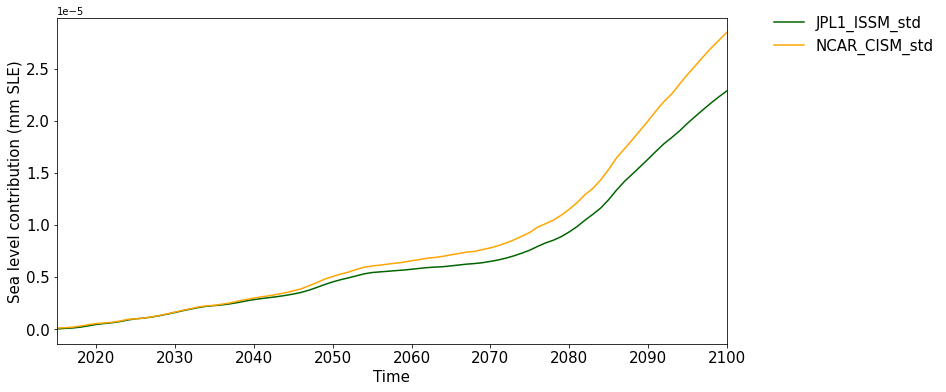

In [310]:
# Fig 4 of https://tc.copernicus.org/articles/14/3033/2020/#App1.Ch1.S2.T7
plt.figure(figsize=(12,6))

SLEmm_issm = sea_level_rise(-relative_total_ice)
SLEmm_cism = sea_level_rise(-relative_total_ice_cism)
plt.plot(years, SLEmm_issm, color='darkgreen', label='JPL1_ISSM_std')
plt.plot(years, SLEmm_cism[1:],color='orange',label='NCAR_CISM_std')
plt.legend(fontsize=15,bbox_to_anchor=(1.05, 1.05),frameon=False)
plt.ylabel(r'Sea level contribution (mm SLE)',fontsize=15)
plt.xlabel('Time',fontsize=15)
#plt.ylim(-0.1e-4,1e-4)
plt.xlim(2015,2100)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)